In [1]:
import gc
from datetime import datetime, timedelta,date
import warnings
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection,johnson_lindenstrauss_min_dim
from sklearn.decomposition import PCA, FastICA,NMF,LatentDirichletAllocation,IncrementalPCA,MiniBatchSparsePCA
from sklearn.decomposition import TruncatedSVD,FactorAnalysis,KernelPCA

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold, KFold

from scipy.stats import ks_2samp
import tqdm

#settings
warnings.filterwarnings('ignore')
np.random.seed(2018)
pd.set_option("display.max_columns", None)

### Utility Function

In [2]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [3]:
def create_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

### 데이터 Load

In [4]:
historical_trans_df = pd.read_csv('input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('input/new_merchant_transactions.csv')
merchant_df = pd.read_csv('input/merchants.csv')

In [5]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

### 기본 전처리

In [6]:
def get_hist_default_prorcessing(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime(2012,4,1) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['reference_date'] = (df['year']+(df['month'] - df['month_lag'])//12)*100 + (((df['month'] - df['month_lag'])%12) + 1)*1
    return df

In [7]:
historical_trans_df = get_hist_default_prorcessing(historical_trans_df)
new_merchant_trans_df = get_hist_default_prorcessing(new_merchant_trans_df)

In [8]:
historical_trans_df = historical_trans_df.sort_values('purchase_date')
new_merchant_trans_df = new_merchant_trans_df.sort_values('purchase_date')

In [10]:
historical_trans_df = pd.get_dummies(historical_trans_df, columns=['category_2', 'category_3'])
new_merchant_trans_df = pd.get_dummies(new_merchant_trans_df, columns=['category_2', 'category_3'])

In [9]:
authorized_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 1]
historical_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 0]

### Feature Engineering

In [10]:
all_df = pd.concat([train_df,test_df])

In [11]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'purchase_amount',['count','mean'])
group_df['card_id_month_lag_purchase_amount_count'] = group_df['card_id_month_lag_purchase_amount_count']/(1-group_df['month_lag'])
group_df['card_id_month_lag_purchase_amount_mean'] = group_df['card_id_month_lag_purchase_amount_mean']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_count',['sum','mean','std'])
mean_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_mean',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')
all_df = all_df.merge(mean_df, on=['card_id'], how='left')

['card_id', 'month_lag'] purchase_amount ['count', 'mean']
['card_id'] card_id_month_lag_purchase_amount_count ['sum', 'mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_mean ['sum', 'mean', 'std']


In [12]:
group_df = groupby_helper(historical_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'month',['nunique','max','min','mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean']


168

In [13]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'merchant_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'subsector_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'subsector_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'state_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'state_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

['card_id'] merchant_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']
['card_id'] state_id ['nunique']


70

In [14]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'city_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'merchant_category_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'subsector_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'state_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] city_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']


In [15]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [16]:
new_columns = create_new_columns('hist',aggs)
historical_trans_group_df = historical_trans_df.groupby('card_id').agg(aggs)
historical_trans_group_df.columns = new_columns
historical_trans_group_df.reset_index(drop=False,inplace=True)
historical_trans_group_df['hist_purchase_date_diff'] = (historical_trans_group_df['hist_purchase_date_max'] - historical_trans_group_df['hist_purchase_date_min']).dt.days
historical_trans_group_df['hist_purchase_date_average'] = historical_trans_group_df['hist_purchase_date_diff']/historical_trans_group_df['hist_card_id_size']
historical_trans_group_df['hist_purchase_date_uptonow'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_max']).dt.days
historical_trans_group_df['hist_purchase_date_uptomin'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_min']).dt.days
all_df = all_df.merge(historical_trans_group_df, on=['card_id'], how='left')

In [17]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
#aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [18]:
new_columns = create_new_columns('new_hist',aggs)
new_merchant_trans_group_df = new_merchant_trans_df.groupby('card_id').agg(aggs)
new_merchant_trans_group_df.columns = new_columns
new_merchant_trans_group_df.reset_index(drop=False,inplace=True)
new_merchant_trans_group_df['new_hist_purchase_date_diff'] = (new_merchant_trans_group_df['new_hist_purchase_date_max'] - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_average'] = new_merchant_trans_group_df['new_hist_purchase_date_diff']/new_merchant_trans_group_df['new_hist_card_id_size']
new_merchant_trans_group_df['new_hist_purchase_date_uptonow'] = (datetime(2012,4,1) - new_merchant_trans_group_df['new_hist_purchase_date_max']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_uptomin'] = (datetime(2012,4,1) - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
#merge with train, test
all_df = all_df.merge(new_merchant_trans_group_df, on=['card_id'], how='left')

In [19]:
def get_train_default_prorcessing(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    #df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['year'] = df['first_active_month'].dt.year
    
    #df['elapsed_time'] = (datetime(2018, 2, 1).date() - df['first_active_month'].dt.date).dt.days
    df['elapsed_time'] = (datetime(2019,1, 20) - df['first_active_month']).dt.days
    #df['after_big_event'] = (datetime(2012,4, 1) - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_hist_purchase_date_max'] - df['first_active_month']).dt.days
    
    df['year_month'] = df['year']*100 + df['month']
    df['hist_diff_reference_date_first'] = 12*(df['hist_reference_date_median']//100 - df['year_month']//100) + (df['hist_reference_date_median']%100 - df['year_month']%100)
    df['hist_diff_reference_date_last'] = 12*(df['hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['new_hist_diff_reference_date_first'] = 12*(df['new_hist_reference_date_median']//100 - df['year_month']//100) + (df['new_hist_reference_date_median']%100 - df['year_month']%100)
    df['new_hist_diff_reference_date_last'] = 12*(df['new_hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['new_hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['hist_diff_first_last'] = df['hist_diff_reference_date_first'] - df['hist_diff_reference_date_last'] 
    df['new_hist_diff_first_last'] = df['new_hist_diff_reference_date_first'] - df['new_hist_diff_reference_date_last'] 
    df['diff_new_hist_date_min_max'] = (df['new_hist_purchase_date_min'] - df['hist_purchase_date_max']).dt.days
    df['diff_new_hist_date_max_max'] = (df['new_hist_purchase_date_max'] - df['hist_purchase_date_max']).dt.days    
    
    
    df['hist_flag_ratio'] = df['hist_authorized_flag_sum'] / df['hist_card_id_size']
    #df['new_flag_ratio'] = df['new_hist_authorized_flag_sum'] / df['new_hist_card_id_size']
    #df['new_hist_flag_ratio'] = 1/(1+df['hist_flag_ratio'])
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_ratio'] = df['new_hist_card_id_size']/df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_hist_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_hist_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_hist_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_hist_purchase_amount_sum']/df['hist_purchase_amount_sum']
    
    df['month_diff_mean'] = df['new_hist_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_hist_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_hist_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_hist_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_hist_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_hist_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_hist_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_hist_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_hist_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_hist_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    
    #df['duration_mean'] = df['new_hist_duration_mean']+df['hist_duration_mean']
    #df['duration_min'] = df['new_hist_duration_min']+df['hist_duration_min']
    #df['duration_max'] = df['new_hist_duration_max']+df['hist_duration_max']
    #df['amount_month_ratio_mean']=df['new_hist_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    #df['amount_month_ratio_min']=df['new_hist_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    #df['amount_month_ratio_max']=df['new_hist_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_hist_card_id_size'] * df['new_hist_purchase_amount_sum'] / df['new_hist_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_size'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
    
    del df['year']
    del df['year_month']
    del df['new_hist_reference_date_median']
    
    return df

In [20]:
all_df = get_train_default_prorcessing(all_df)

In [21]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'authorized_flag',['sum'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
all_df['new_flag_ratio'] = all_df['new_hist_card_id_authorized_flag_sum'] / all_df['new_hist_card_id_size']
all_df['new_hist_flag_ratio'] = all_df['new_flag_ratio']/(all_df['new_flag_ratio']+all_df['hist_flag_ratio'])
del all_df['new_hist_card_id_authorized_flag_sum']

['card_id'] authorized_flag ['sum']


In [22]:
all_df['feature123'] = all_df['feature_1'].astype(str) +'_'+all_df['feature_2'].astype(str)+'_'+all_df['feature_3'].astype(str)
all_df['feature123'] = pd.factorize(all_df['feature123'])[0]

In [23]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'subsector_id',['nunique'])
group_df['card_id_month_lag_subsector_id_nunique'] = group_df['card_id_month_lag_subsector_id_nunique']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_subsector_id_nunique',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')

['card_id', 'month_lag'] subsector_id ['nunique']
['card_id'] card_id_month_lag_subsector_id_nunique ['sum', 'mean', 'std']


In [24]:
group_df_mode = pd.read_csv('input/subsector_id_mode.csv')
group_df = groupby_helper(group_df_mode.reset_index(),'card_id', 'subsector_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

card_id subsector_id ['nunique']


In [25]:
group_df_mode_mci = pd.read_csv('input/merchant_category_id_mode.csv')
group_df = groupby_helper(group_df_mode_mci.reset_index(),'card_id', 'merchant_category_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

card_id merchant_category_id ['nunique']


firstactive month보다 작거나 같은 달의 거래횟수 / 전체 거래횟수

In [60]:
historical_trans_df =historical_trans_df.merge(all_df[['card_id','first_active_month','target','feature123']], on='card_id',how='left')
historical_trans_df['ym'] = historical_trans_df['purchase_date'].dt.year*100 + historical_trans_df['purchase_date'].dt.month
historical_trans_df['first_active_month_ym'] = historical_trans_df['first_active_month'].dt.year*100 + historical_trans_df['first_active_month'].dt.month
historical_trans_df['is_smaller_firstactive'] = 0
historical_trans_df.loc[historical_trans_df['ym']<=historical_trans_df['first_active_month_ym'],'is_smaller_firstactive'] = 1
group_df = groupby_helper(historical_trans_df,'card_id', 'is_smaller_firstactive',['sum'])
temp = groupby_helper(historical_trans_df,'card_id', 'card_id',['size'])
group_df = group_df.merge(temp, on='card_id', how='left')
group_df['before_firstactive_purchase_ratio']=group_df['card_id_is_smaller_firstactive_sum'] /group_df['card_id_card_id_size']
all_df = all_df.merge(group_df[['card_id','before_firstactive_purchase_ratio']], on=['card_id'], how='left')

merchant merge 후 merchant category에 있는 것 구현해보기

In [44]:
monthlag_last = groupby_helper(historical_trans_df,['card_id'],'month_lag',['max'])
historical_trans_df = historical_trans_df.merge(monthlag_last, on='card_id', how='left')
historical_trans_df.loc[historical_trans_df['month_lag']==historical_trans_df['card_id_month_lag_max'],'month_lag_reference'] = 1
historical_trans_df['month_lag_reference'].fillna(0, inplace=True)

"""
monthlag_last = groupby_helper(historical_trans_df.loc[historical_trans_df['month_lag_reference']!=0],['card_id'],'month_lag',['max'],'before')
historical_trans_df = historical_trans_df.merge(monthlag_last, on='card_id', how='left')
historical_trans_df.loc[historical_trans_df['month_lag']==historical_trans_df['before_card_id_month_lag_max'],'month_lag_reference'] = 1
historical_trans_df['month_lag_reference'].fillna(0, inplace=True)
"""
group_df = groupby_helper(historical_trans_df.loc[historical_trans_df['month_lag_reference']==0],['card_id'],'month_lag',['nunique'])
historical_trans_df = historical_trans_df.merge(group_df,on='card_id',how='left')
historical_trans_df.loc[historical_trans_df['card_id_month_lag_nunique'].isnull(),'card_id_month_lag_nunique'] = 0
card_id_month_lag_nunique = groupby_helper(historical_trans_df,['card_id'],'card_id_month_lag_nunique',['max'])

['card_id'] month_lag ['max']
['card_id'] month_lag ['nunique']
['card_id'] card_id_month_lag_nunique ['max']


In [89]:
historical_trans_df = historical_trans_df.merge(merchant_df[['merchant_id', 'merchant_group_id','numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4']], on='merchant_id', how='left')

In [225]:
new_merchant_trans_df = new_merchant_trans_df.merge(merchant_df[['merchant_id', 'merchant_group_id','numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4']], on='merchant_id', how='left')

In [226]:
new_merchant_trans_df['most_sales_purchases_range'] = new_merchant_trans_df['most_recent_sales_range'] +new_merchant_trans_df['most_recent_purchases_range']

In [ ]:
historical_trans_df['most_sales_purchases_range'] = historical_trans_df['most_recent_sales_range'] +historical_trans_df['most_recent_purchases_range']

In [215]:
def refmonth_remain_groupby(hist, targetcol, remain_month, prefix, agg='size'):
    group_df = groupby_helper(hist, ['card_id','month_lag_reference'], targetcol, [agg])
    new_col = 'card_id_month_lag_reference_{}_{}'.format(targetcol,agg )
    group_df = group_df.pivot('card_id','month_lag_reference',new_col).reset_index()
    group_df.columns = ['card_id','{}_{}_0'.format(prefix,new_col),'{}_{}_1'.format(prefix,new_col)]
    group_df = group_df.merge(remain_month, on='card_id', how='left')
    group_df['{}_{}_0'.format(prefix,new_col)] = group_df['{}_{}_0'.format(prefix,new_col)] / group_df['card_id_card_id_month_lag_nunique_max']
    group_df['{}_{}_1'.format(prefix,new_col)] = group_df['{}_{}_1'.format(prefix,new_col)] / 1
    del group_df['card_id_card_id_month_lag_nunique_max']
    group_df['{}_{}_ratio'.format(prefix,new_col)] = group_df['{}_{}_0'.format(prefix,new_col)] / group_df['{}_{}_1'.format(prefix,new_col)]
    del group_df['{}_{}_0'.format(prefix,new_col)]
    del group_df['{}_{}_1'.format(prefix,new_col)]
    group_df.fillna(0, inplace=True)
    group_df.loc[np.isinf(group_df['{}_{}_ratio'.format(prefix,new_col)]),'{}_{}_ratio'.format(prefix,new_col)] = 0
    return group_df

In [142]:
group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='AA'], 'card_id', card_id_month_lag_nunique,'merchant_AA')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='BB'], 'card_id', card_id_month_lag_nunique,'merchant_BB')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='CC'], 'card_id', card_id_month_lag_nunique,'merchant_CC')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='DD'], 'card_id', card_id_month_lag_nunique,'merchant_DD')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='EE'], 'card_id', card_id_month_lag_nunique,'merchant_EE')
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']


In [182]:
group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='DC'], 'card_id', card_id_month_lag_nunique,'merchant_DC')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='CB'], 'card_id', card_id_month_lag_nunique,'merchant_CB')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='BA'], 'card_id', card_id_month_lag_nunique,'merchant_BA')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='ED'], 'card_id', card_id_month_lag_nunique,'merchant_ED')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='CD'], 'card_id', card_id_month_lag_nunique,'merchant_CD')
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = refmonth_remain_groupby(historical_trans_df.loc[historical_trans_df['most_sales_purchases_range']=='BC'], 'card_id', card_id_month_lag_nunique,'merchant_BC')
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']
['card_id', 'month_lag_reference'] card_id ['size']


In [276]:
group_df = groupby_helper(new_merchant_trans_df.loc[new_merchant_trans_df['most_sales_purchases_range']=='CC'], 'card_id', 'card_id', ['size'],'new_hist_merchant_CC')
temp = groupby_helper(new_merchant_trans_df, 'card_id', 'month_lag', ['nunique'])
group_df = group_df.merge(temp, on='card_id', how='left')
group_df['new_hist_merchant_CC_card_id_card_id_size'] = group_df['new_hist_merchant_CC_card_id_card_id_size']/group_df['card_id_month_lag_nunique']
all_df = all_df.merge(group_df[['card_id','new_hist_merchant_CC_card_id_card_id_size']],on='card_id', how='left' )

card_id card_id ['size']
card_id month_lag ['nunique']


In [311]:
historical_trans_df['person_purchase_ratio'] = historical_trans_df['avg_sales_lag3'] / historical_trans_df['avg_purchases_lag3']
group_df = refmonth_remain_groupby(historical_trans_df, 'person_purchase_ratio', card_id_month_lag_nunique,'',agg='sum')
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id', 'month_lag_reference'] person_purchase_ratio ['sum']


two group merchantid 실패

In [305]:
historical_trans_df['category_4'] = historical_trans_df['category_4'].map({'Y':1,'N':0})
group_df = refmonth_remain_groupby(historical_trans_df, 'category_4', card_id_month_lag_nunique,prefix='category_4' ,agg='sum')
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id', 'month_lag_reference'] category_4 ['sum']


In [296]:
historical_trans_df.loc[historical_trans_df['category_4'].isnull(),'category_4_isnull'] = 1
group_df = refmonth_remain_groupby(historical_trans_df, 'category_4_isnull', card_id_month_lag_nunique,agg='sum')
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id', 'month_lag_reference'] category_4_isnull ['sum']


In [217]:
group_df = refmonth_remain_groupby(historical_trans_df, 'numerical_1', card_id_month_lag_nunique,'numerical_1',agg='sum')
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id', 'month_lag_reference'] numerical_1 ['sum']


In [80]:
temp = merchant_df.groupby(['merchant_id'])['merchant_group_id'].nunique().reset_index()
merchant_two_group_card_id = historical_trans_df.loc[historical_trans_df['merchant_id'].isin(temp.loc[temp['merchant_group_id']>1,'merchant_id'].values),'card_id'].unique()
all_df['two_category_group_merchant'] = 0
all_df.loc[all_df['card_id'].isin(merchant_two_group_card_id),'two_category_group_merchant'] = 1

monthlag nunique - 실패

In [32]:
group_df = groupby_helper(historical_trans_df,'card_id', 'month_lag',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

card_id month_lag ['nunique']


#### Is Null or Negative -1 Feature
state_id, merchant_category_id, city_id, subsector_id = -1 <br>
installments = -1, 999 <br>
category_2, category_3 = null<br>
대부분은 실패하고 installments만 살아남음

In [177]:
historical_trans_df.loc[historical_trans_df['category_2'].isnull(),'category_2_isnull'] = 1
historical_trans_df.loc[historical_trans_df['category_3'].isnull(),'category_3_isnull'] = 1
historical_trans_df.loc[historical_trans_df['state_id']==-1, 'state_id_isnull'] = 1
historical_trans_df.loc[historical_trans_df['merchant_category_id']==-1, 'merchant_category_id_minus1'] = 1
historical_trans_df.loc[historical_trans_df['city_id']==-1, 'city_id_minus1'] = 1
historical_trans_df.loc[historical_trans_df['subsector_id']==-1, 'subsector_id_minus1'] = 1
historical_trans_df.loc[(historical_trans_df['installments']==-1)|(historical_trans_df['installments']==999), 'installments_minus1'] = 1

평가기간(ref, ref-1) vs 나머지 기간 mask

In [44]:
monthlag_last = groupby_helper(historical_trans_df,['card_id'],'month_lag',['max'])
historical_trans_df = historical_trans_df.merge(monthlag_last, on='card_id', how='left')
historical_trans_df.loc[historical_trans_df['month_lag']==historical_trans_df['card_id_month_lag_max'],'month_lag_reference'] = 1
historical_trans_df['month_lag_reference'].fillna(0, inplace=True)

"""
monthlag_last = groupby_helper(historical_trans_df.loc[historical_trans_df['month_lag_reference']!=0],['card_id'],'month_lag',['max'],'before')
historical_trans_df = historical_trans_df.merge(monthlag_last, on='card_id', how='left')
historical_trans_df.loc[historical_trans_df['month_lag']==historical_trans_df['before_card_id_month_lag_max'],'month_lag_reference'] = 1
historical_trans_df['month_lag_reference'].fillna(0, inplace=True)
"""
group_df = groupby_helper(historical_trans_df.loc[historical_trans_df['month_lag_reference']==0],['card_id'],'month_lag',['nunique'])
historical_trans_df = historical_trans_df.merge(group_df,on='card_id',how='left')
historical_trans_df.loc[historical_trans_df['card_id_month_lag_nunique'].isnull(),'card_id_month_lag_nunique'] = 0
card_id_month_lag_nunique = groupby_helper(historical_trans_df,['card_id'],'card_id_month_lag_nunique',['max'])

['card_id'] month_lag ['max']
['card_id'] month_lag ['nunique']
['card_id'] card_id_month_lag_nunique ['max']


In [120]:
def refmonth_remain_groupby(hist, targetcol, remain_month):
    group_df = groupby_helper(hist, ['card_id','month_lag_reference'], targetcol, ['sum'])
    new_col = 'card_id_month_lag_reference_{}_sum'.format(targetcol)
    group_df = group_df.pivot('card_id','month_lag_reference',new_col).reset_index()
    group_df.columns = ['card_id','{}_0'.format(new_col),'{}_1'.format(new_col)]
    group_df = group_df.merge(remain_month, on='card_id', how='left')
    group_df['{}_0'.format(new_col)] = group_df['{}_0'.format(new_col)] / group_df['card_id_card_id_month_lag_nunique_max']
    group_df['{}_1'.format(new_col)] = group_df['{}_1'.format(new_col)] / 1
    del group_df['card_id_card_id_month_lag_nunique_max']
    group_df['{}_ratio'.format(new_col)] = group_df['{}_0'.format(new_col)] / group_df['{}_1'.format(new_col)]
    #del group_df['{}_0'.format(new_col)]
    #del group_df['{}_1'.format(new_col)]
    group_df.fillna(0, inplace=True)
    group_df.loc[np.isinf(group_df['{}_ratio'.format(new_col)]),'{}_ratio'.format(new_col)] = 0
    return group_df

In [336]:
group_df = refmonth_remain_groupby(historical_trans_df, 'installments_minus1', card_id_month_lag_nunique)
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id', 'month_lag_reference'] installments_minus1 ['sum']


### New Feature Test

In [26]:
for col in all_df.columns:
    if col.find('weekend') !=-1:
        print(col)
        del all_df[col]

hist_weekend_sum
hist_weekend_mean
hist_weekend_min
hist_weekend_max
new_hist_weekend_sum
new_hist_weekend_mean
new_hist_weekend_min
new_hist_weekend_max


In [315]:
for col in all_df.columns:
    if col.find('_card_id_month_lag_reference_person_purchase_ratio_sum_ratio') !=-1:
        print(col)
        del all_df[col]

_card_id_month_lag_reference_person_purchase_ratio_sum_ratio


In [114]:
for col in all_df.columns:
    if all_df[col].nunique() == 1:
        print(col)
        del all_df[col]

In [181]:
for col in all_df.columns:
    if col in ['new_hist_year_max', 'hist_year_max', 'hist_authorized_flag_min',
       'new_hist_year_min','new_hist_diff_first_last', 'hist_category_1_min',
       'new_hist_category_1_max', 'hist_category_1_max']:
        print(col)
        del all_df[col]

merchant_DC_card_id_month_lag_reference_card_id_size_ratio
merchant_CB_card_id_month_lag_reference_card_id_size_ratio
merchant_CD_card_id_month_lag_reference_card_id_size_ratio
merchant_BC_card_id_month_lag_reference_card_id_size_ratio
merchant_BA_card_id_month_lag_reference_card_id_size_ratio
merchant_ED_card_id_month_lag_reference_card_id_size_ratio


In [316]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]

#train_df['target'] = np.power(2,train_df['target'])-1e-10

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [317]:
train = train_df.copy()
target = train['target']
del train['target']

In [318]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

feature_importance_df = pd.DataFrame()
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
cv_score_list = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    cv_score = np.sqrt(mean_squared_error(oof[val_idx], target.iloc[val_idx]))
    cv_score_list.append(cv_score)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
print(cv_score_list)
print(np.std(cv_score_list))
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.60725	valid_1's rmse: 3.68641
[200]	training's rmse: 3.52283	valid_1's rmse: 3.66424
[300]	training's rmse: 3.46714	valid_1's rmse: 3.65821
[400]	training's rmse: 3.42435	valid_1's rmse: 3.65385
[500]	training's rmse: 3.3879	valid_1's rmse: 3.65055
[600]	training's rmse: 3.35601	valid_1's rmse: 3.64871
[700]	training's rmse: 3.32749	valid_1's rmse: 3.6475
[800]	training's rmse: 3.30051	valid_1's rmse: 3.64726
[900]	training's rmse: 3.27383	valid_1's rmse: 3.64555
[1000]	training's rmse: 3.24934	valid_1's rmse: 3.64569
Early stopping, best iteration is:
[961]	training's rmse: 3.25879	valid_1's rmse: 3.64518
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.60387	valid_1's rmse: 3.70246
[200]	training's rmse: 3.51756	valid_1's rmse: 3.67886
[300]	training's rmse: 3.46194	valid_1's rmse: 3.67078
[400]	training's rmse: 3.42018	valid_1's rmse: 3.66619
[

3.639314813568998
[3.645178313151862, 3.662021769173542, 3.634443771355322, 3.612686301356376, 3.682000328795896, 3.5924892751780346, 3.6490574683168795, 3.6116868372373143, 3.6633429370021116]
0.027351528909594684

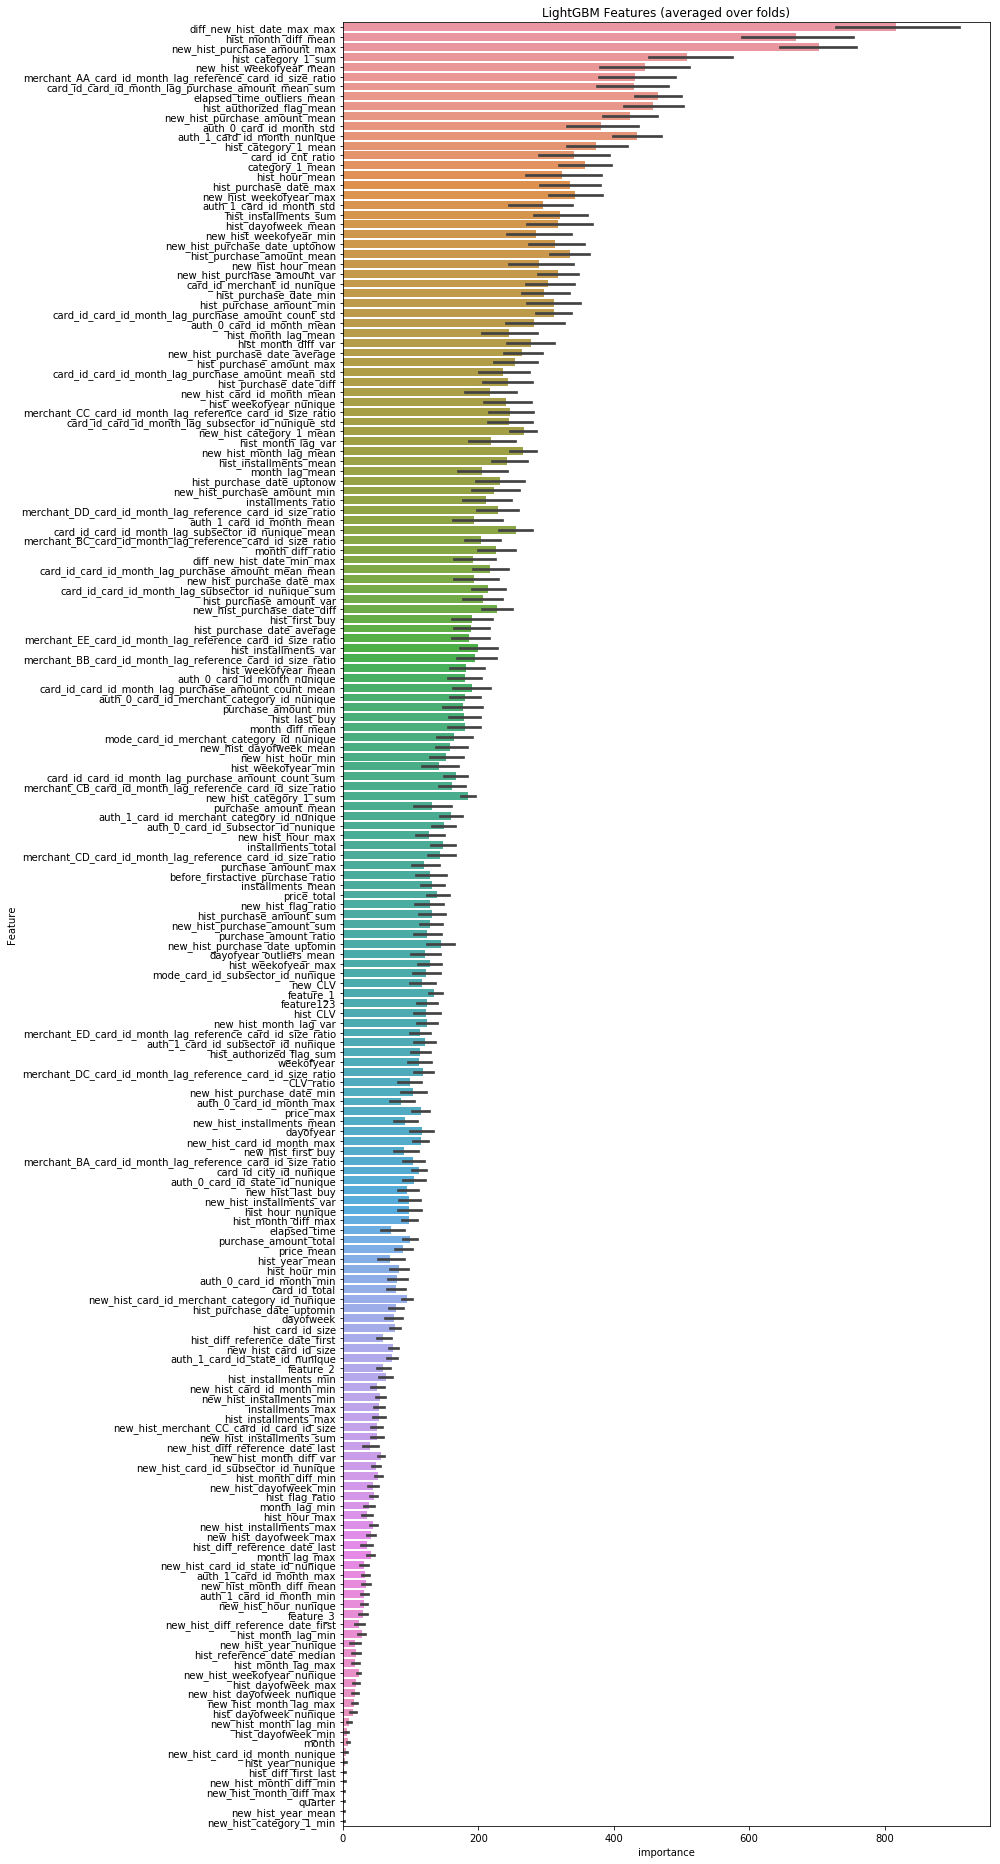

In [319]:
filename = '{}_cv{:.6f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), cv_score)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('fi/{}_lgbm_importances.png'.format(filename))

In [320]:
feature_importance_df.groupby('Feature')['importance'].sum().reset_index().sort_values('importance')

,Feature,importance
127,new_hist_category_1_min,6
171,new_hist_year_mean,10
181,quarter,13
148,new_hist_month_diff_max,14
150,new_hist_month_diff_min,16
53,hist_diff_first_last,18
93,hist_year_nunique,24
122,new_hist_card_id_month_nunique,39
51,hist_dayofweek_min,50
111,month,63


In [321]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df['target'] = predictions
#sub_df.loc[sub_df['target']<-9,'target'] = -33.21928095
sub_df.to_csv("output/combine_submission_{}.csv".format(filename), index=False)

# Post Processing

### without Outlier

In [322]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
train_df = train_df.loc[train_df['target']>-30]
"""
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_df = train_df.loc[train_df['target']>-30]
"""
train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [323]:
train = train_df.copy()
target = train['target']
del train['target']

In [324]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.58879	valid_1's rmse: 1.58116
[200]	training's rmse: 1.5615	valid_1's rmse: 1.55857
[300]	training's rmse: 1.54762	valid_1's rmse: 1.54983
[400]	training's rmse: 1.53753	valid_1's rmse: 1.54528
[500]	training's rmse: 1.52944	valid_1's rmse: 1.54314
[600]	training's rmse: 1.52246	valid_1's rmse: 1.54211
[700]	training's rmse: 1.51608	valid_1's rmse: 1.54101
[800]	training's rmse: 1.51001	valid_1's rmse: 1.54058
[900]	training's rmse: 1.50428	valid_1's rmse: 1.54057
[1000]	training's rmse: 1.49869	valid_1's rmse: 1.54037
[1100]	training's rmse: 1.49343	valid_1's rmse: 1.54018
[1200]	training's rmse: 1.48821	valid_1's rmse: 1.53995
[1300]	training's rmse: 1.48297	valid_1's rmse: 1.53965
[1400]	training's rmse: 1.47785	valid_1's rmse: 1.53938
[1500]	training's rmse: 1.47295	valid_1's rmse: 1.53942
Early stopping, best iteration is:
[1452]	training's rmse: 1.47518	valid_1's rmse: 1.53927
fold 2
Tr

[1700]	training's rmse: 1.46211	valid_1's rmse: 1.55063
Early stopping, best iteration is:
[1621]	training's rmse: 1.46587	valid_1's rmse: 1.55055
fold 9
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.5857	valid_1's rmse: 1.60285
[200]	training's rmse: 1.55813	valid_1's rmse: 1.58232
[300]	training's rmse: 1.54404	valid_1's rmse: 1.5748
[400]	training's rmse: 1.53407	valid_1's rmse: 1.57102
[500]	training's rmse: 1.52591	valid_1's rmse: 1.56872
[600]	training's rmse: 1.51898	valid_1's rmse: 1.56779
[700]	training's rmse: 1.51247	valid_1's rmse: 1.56689
[800]	training's rmse: 1.50645	valid_1's rmse: 1.56642
[900]	training's rmse: 1.5008	valid_1's rmse: 1.56613
[1000]	training's rmse: 1.49524	valid_1's rmse: 1.56569
[1100]	training's rmse: 1.48994	valid_1's rmse: 1.56541
[1200]	training's rmse: 1.48465	valid_1's rmse: 1.56527
[1300]	training's rmse: 1.47962	valid_1's rmse: 1.56504
[1400]	training's rmse: 1.47443	valid_1's rmse: 1.56497
[1500]	trai

In [325]:
model_without_outliers = pd.DataFrame({"card_id":test_df["card_id"].values})
model_without_outliers["target"] = withoutoutlier_predictions

### outlier

In [326]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
#train_df = train_df.loc[train_df['target']>-30]

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [327]:
train = train_df.copy()
target = train['outliers']
del train['target']
del train['outliers']

In [328]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "random_state": 6}

folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_+1))

    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(log_loss(target, oof)))

fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0445297	valid_1's binary_logloss: 0.0473978
[200]	training's binary_logloss: 0.0410909	valid_1's binary_logloss: 0.0451618
[300]	training's binary_logloss: 0.0391847	valid_1's binary_logloss: 0.0444833
[400]	training's binary_logloss: 0.037829	valid_1's binary_logloss: 0.0442472
[500]	training's binary_logloss: 0.0365959	valid_1's binary_logloss: 0.0441347
[600]	training's binary_logloss: 0.0353879	valid_1's binary_logloss: 0.0440814
[700]	training's binary_logloss: 0.0342605	valid_1's binary_logloss: 0.0440452
[800]	training's binary_logloss: 0.0331533	valid_1's binary_logloss: 0.0440288
[900]	training's binary_logloss: 0.0321592	valid_1's binary_logloss: 0.0440409
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.0335788	valid_1's binary_logloss: 0.0440193
fold 2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0

[700]	training's binary_logloss: 0.0346958	valid_1's binary_logloss: 0.0412961
[800]	training's binary_logloss: 0.0336236	valid_1's binary_logloss: 0.0413065
[900]	training's binary_logloss: 0.0326137	valid_1's binary_logloss: 0.041293
[1000]	training's binary_logloss: 0.0316853	valid_1's binary_logloss: 0.0412956
[1100]	training's binary_logloss: 0.0307471	valid_1's binary_logloss: 0.0413391
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.0323317	valid_1's binary_logloss: 0.0412737
CV score: 0.04355 


In [329]:
df_outlier_prob = pd.DataFrame({"card_id":test_df["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.sort_values('target',ascending=False)

,card_id,target
104991,C_ID_86ddafb51c,0.699220
20556,C_ID_aae50409e7,0.670953
32446,C_ID_ac114ef831,0.600001
5008,C_ID_be92f84f5c,0.598558
119449,C_ID_3d40705001,0.586647
80840,C_ID_bced41d837,0.574951
19114,C_ID_0be3fb41d2,0.571161
37421,C_ID_366bf4ea4d,0.564147
7750,C_ID_a74b12dcf8,0.562274
27384,C_ID_1a23d403c3,0.557836


In [330]:
outlier_id = pd.read_csv('best_lb_outlier_id.csv')
top20_outlier_id = pd.read_csv('best_lb_top20_outlier_id.csv')
#outlier_id = pd.DataFrame(df_outlier_prob.sort_values('target',ascending=False).head(30000)['card_id'])

In [331]:
outlier_id_temp = pd.DataFrame(list(set(df_outlier_prob.loc[df_outlier_prob['target']>0.00203,'card_id'].values).intersection(set(outlier_id['card_id'].values))),columns=['card_id'])
len(set(outlier_id['card_id'].values).intersection(set(outlier_id_temp['card_id'].values)))

27982

In [332]:
outlier_id = outlier_id_temp.copy()

In [338]:
set(df_outlier_prob.loc[df_outlier_prob['target']>0.5,'card_id'].values)

{'C_ID_0be3fb41d2',
 'C_ID_1a23d403c3',
 'C_ID_26f775a95b',
 'C_ID_366bf4ea4d',
 'C_ID_3d40705001',
 'C_ID_493de71141',
 'C_ID_74dd007aec',
 'C_ID_833aa2f7af',
 'C_ID_86ddafb51c',
 'C_ID_91cc0c06ca',
 'C_ID_a74b12dcf8',
 'C_ID_aae50409e7',
 'C_ID_ac114ef831',
 'C_ID_afbfc01b49',
 'C_ID_b237ce01cb',
 'C_ID_b248952695',
 'C_ID_bced41d837',
 'C_ID_be92f84f5c',
 'C_ID_e7f772dfc0',
 'C_ID_fe89c1890a'}

In [337]:
len(set(df_outlier_prob.loc[df_outlier_prob['target']>0.5,'card_id'].values).union(set(top20_outlier_id['card_id'].values)))

34

### Best Submission

In [76]:
hyeonwoo_without_outlier = pd.read_csv('hyeonwoo_without_outlier.csv')
hyeonwoo_without_outlier.columns = ['card_id', 'h_target']

In [77]:
combine_hy_without_outlier = model_without_outliers.merge(hyeonwoo_without_outlier, on='card_id',how='left')
combine_hy_without_outlier['target'] = combine_hy_without_outlier['target']*0.3 + combine_hy_without_outlier['h_target']*0.7
del combine_hy_without_outlier['h_target']

In [78]:
hyeonwoo_best = pd.read_csv('output/v7_3.6434855490056766.csv')
my_best = pd.read_csv('output/combine_submission_20190205_182031_cv3.642718.csv')
my_best['target'] = hyeonwoo_best['target']*0.75 + my_best['target']*0.25
best_submission = my_best.copy()
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [79]:
only_without_outliers = combine_hy_without_outlier.loc[~combine_hy_without_outlier['card_id'].isin(most_likely_liers['card_id'].unique())]
submission = pd.concat([only_without_outliers, most_likely_liers])

In [80]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df = sub_df.merge(submission, on='card_id',how='left')
sub_df.loc[sub_df['card_id'].isin(top20_outlier_id['card_id'].values),'target'] = -33.21928095
sub_df.to_csv("output/submission_blend_blend4.csv", index=False)